## Linear contrast growth

In [421]:
import numpy as np
import scipy

# read profile
parsec_in_cm = 3.086e18  # (cm)
sec_in_yr = 3.15576e7  # (s)

scale_height = 50. # kpc
sample_height = 0.25 * scale_height

def get_cooling_time(height, profile=None):
    """return cooling time in Myr."""
    #profile = "inputs/hse_alpha_0_tc_tff_0.1.txt"
    z, rho, P, g, n, K, phi = np.loadtxt(profile, unpack=True)
    kB = 1.3806488e-16  # parthenon value
    Lambda = 1.0e-22  # cgs  (cooling rate at T_0)
    T = P / (n * kB)
    tcool = (3./2.) * kB * T / (n * Lambda) # s
    interp = scipy.interpolate.interp1d(z, tcool)
    return interp(height) / sec_in_yr / 1.0e6

def get_time(file):
    """return time from csv file."""
    with open(file) as f:
        lines = f.readlines()
        header = lines[0]
        parts = header.split(" = ")
        time = float(parts[1])
        return time
    
## fit growth profile to line
def growth_fit(t, f):
    """ordinary least-squares fit: log f = A*t + B.
    return A^{-1}."""
    import scipy.stats
    ## find first index for which drho/rho > 0.1
    f_arr = np.asarray(f)
    t_arr = np.asarray(t)
    max_idx = -1
    linear_max = 0.02
    if np.max(f_arr) > linear_max:
        max_idx = np.nonzero(f_arr > linear_max)[0][0]
    fit = scipy.stats.linregress(t_arr[:max_idx], np.log(f_arr[:max_idx]))
    return 1.0/fit.slope

def filename_tuple_generator(i):
    return (dir + "/drho_rms" + str(i).zfill(5) + ".csv", dir + "/mach_rms" + str(i).zfill(5) + ".csv")

def get_files(dir, max_snapshots=200):
    from pathlib import Path
    candidate_files = [filename_tuple_generator(i) for i in range(max_snapshots)]
    files = []
    for file_tuple in candidate_files:
        all_exist = True
        for file in file_tuple:
            if not Path(file).exists():
                all_exist = False
        if all_exist:
            files.append(file_tuple)
    return files

def get_timeseries(dir="."):
    drho_arr = []
    rms_mach_arr = []
    time_arr = []

    files = get_files(dir)
    for drho_file, rms_mach_file in files:
        z, drho_over_rho = np.loadtxt(drho_file, unpack=True)
        z, rms_mach = np.loadtxt(rms_mach_file, unpack=True)
        drho_interp = scipy.interpolate.interp1d(z, drho_over_rho)
        rms_mach_interp = scipy.interpolate.interp1d(z, rms_mach)
        drho_arr.append(drho_interp(sample_height))
        rms_mach_arr.append(rms_mach_interp(sample_height))
        time_arr.append(get_time(drho_file))

    return dir, time_arr, drho_arr, rms_mach_arr

In [430]:
dirs = [(0.1, "tc_tff_0.1"), (0.2, "tc_tff_0.2"), (0.3, "tc_tff_0.3"), (0.4, "tc_tff_0.4"), (0.5, "tc_tff_0.5"), (1.0, "tc_tff_1.0")]
data = []
for tc_tff, dir in dirs:
    data.append((tc_tff, get_timeseries(dir)))

0.1 growth time = 45.770553363659474 Myr
0.2 growth time = 81.92097451287218 Myr
0.3 growth time = 124.08702443490519 Myr
0.4 growth time = 180.67699926546248 Myr
0.5 growth time = 274.30577426754235 Myr
1.0 growth time = 904.5454276744533 Myr


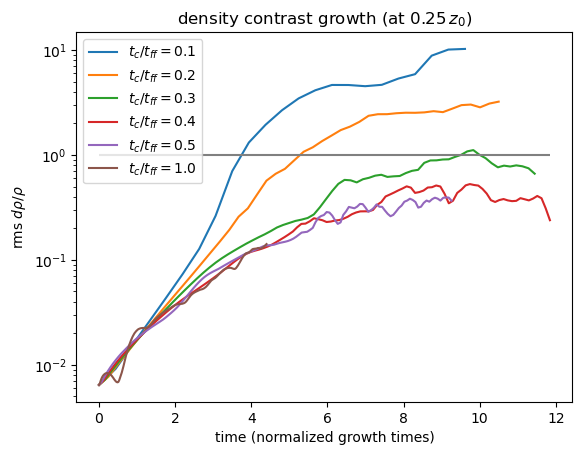

In [431]:
import matplotlib.pyplot as plt

max_time = -np.inf
for ts in data:
    tc_tff, (ts_name, time_arr, drho_arr, Mach_arr) = ts
    growth_time_Myr = growth_fit(time_arr, drho_arr)
    print(str(tc_tff) + " growth time =", growth_time_Myr, "Myr")
    max_time = np.maximum(max_time, np.max(time_arr / growth_time_Myr))
    plt.plot(time_arr / growth_time_Myr, drho_arr, label=r"$t_c/t_{ff}=" + str(tc_tff) + r"$")

plt.hlines(xmin=0, xmax=max_time, y=1.0, color='gray')
plt.xlabel("time (normalized growth times)")
plt.ylabel(r"rms $d \rho / \rho$")
plt.yscale('log')
plt.title(r"density contrast growth (at $0.25 \, z_0$)")
plt.legend(loc='best')

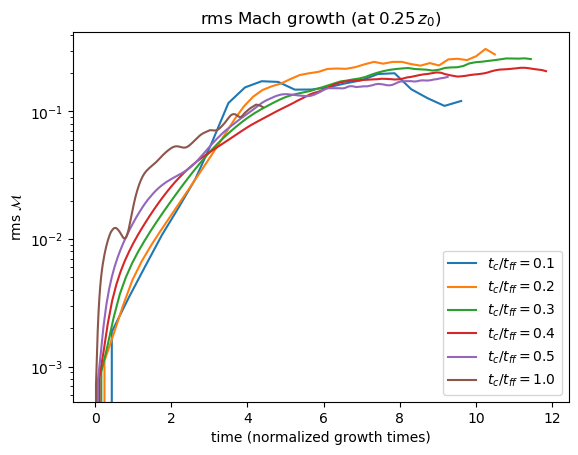

In [432]:
for ts in data:
    tc_tff, (ts_name, time_arr, drho_arr, Mach_arr) = ts
    growth_time_Myr = growth_fit(time_arr, drho_arr)
    plt.plot(time_arr / growth_time_Myr, Mach_arr, label=r"$t_c/t_{ff}=" + str(tc_tff) + r"$")

plt.xlabel("time (normalized growth times)")
plt.ylabel(r"rms $\mathcal{M}$")
plt.yscale('log')
plt.title(r"rms Mach growth (at $0.25 \, z_0$)")
plt.legend(loc='best')

Text(0, 0.5, 'growth time / cooling time')

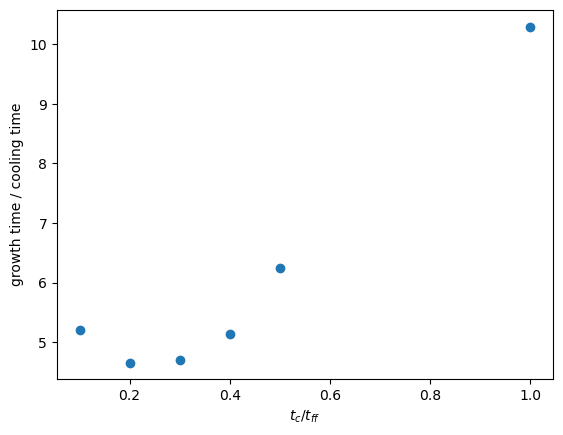

In [433]:
tc_tff_arr = []
growth_time_arr = []
cooling_time_arr = []
for ts in data:
    tc_tff, (ts_name, time_arr, drho_arr, Mach_arr) = ts
    growth_time_Myr = growth_fit(time_arr, drho_arr)
    cooling_time_Myr = get_cooling_time(sample_height * 1.0e3 * parsec_in_cm, profile="inputs/hse_alpha_0_tc_tff_" + str(tc_tff) + ".txt")
    tc_tff_arr.append(tc_tff)
    growth_time_arr.append(growth_time_Myr)
    cooling_time_arr.append(cooling_time_Myr)

plt.scatter(tc_tff_arr, np.asarray(growth_time_arr)/np.asarray(cooling_time_arr))
plt.xlabel(r"$t_c / t_{ff}$")
plt.ylabel("growth time / cooling time")
#plt.yscale('log')